## Neuronales Netz zur Bilderkennung trainieren
<br/>

-  MNIST dataset beinhaltet handschriftlich geschriebene Ziffern. Diese soll das Neuronale Netz erkennen. 
-  Exemplarische Ziffern-Bilder siehe unten (5,0,4,1,9).
-  Verwendet wird hier nur eine Teilmenge des populären MNIST-datasets, um beim Trainingsprozess Rechenzeit zu sparen.
-  Der Trainingsdatensatz besteht aus 100 Bildern, wobei jedes Bild aus 28 X 28 Pixeln = 784 Werten / Pixeln besteht. 
-  Die Pixel sind in Grauabstufungen kodiert. Wertebereich: [0, 255]
-  Zusätzlich beeinhaltet jeder Datensatz an erster Stelle die gesuchte Ziffer (das Target).

#### Trainingsdatensatz einlesen und exemplarisch davon ein paar Bilder ausgeben lassen

In [20]:
data_file = open("mnist_train_100.csv", 'r')
data_list = data_file.readlines() # ganze Datei in Hauptspeicher laden, nicht empfehlenswert, aber hier okay !
data_file.close()

len(data_list) 

100

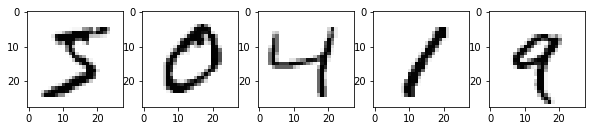

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Anzeige der ersten 5 Bilder im Trainingsdatensatz:
bilder_anzeigen = 5

f, axarr = plt.subplots(ncols= bilder_anzeigen, figsize=(10, 10))

for i in range(bilder_anzeigen):
    alle_werte = data_list[i].split(',') # Pixel des i-ten Bild einlesen und Kommas entfernen
    bild_array = np.asfarray(alle_werte[1:]).reshape((28,28)) # Erster Wert Liste(= target) abtrennen, reshape und Formatierung als Zahl
    np.append(bild_array, bild_array, axis = 0)    
    axarr[i].imshow(bild_array, cmap = 'Greys', interpolation = 'None') # Plotting 

#### Trainingsdatensatz vorbereiten
<br/>

-  Skalierung Trainingsdaten auf optimalen Bereich der Aktivierungsfunktion
-  Elimierung Nullwerte aus skaliertem Datensatz.
-  Nullgewichte blockieren Lernfähigkeit des Neuronalen Netzes (bzw. Gewichtsaktualisierung)

In [3]:
# Skalierung Pixel erstes Bild auf Wertebereich [0.01, 0.99]
input_skaliert = (np.asfarray(alle_werte[1:]) / 255.0 * 0.99) + 0.01

#### Zielmatrix / Target vorbereiten

-  Der erste Wert einer jeder Bilderliste gibt die handgeschriebene Zahl an, welche auf dem Bild zu erkennen ist
-  Für oben gezeigte Biderlisten fünf Bilderlisten sind die Ziel-Werte dementsprechend 5,0,4,1 und 9.
-  Da Aktiverungsfunktion der Output-Schicht weder 0 noch 1 erzeugen kann, ist Wertebereich target [0.01, 0.99].
-  Ansonsten würde eine gesättigtes Netz entstehen bei dem Gewichte unnötig in die Höhe getrieben werden.

In [4]:
# Erzeugung Zielmatrix für erstes Bild
output_nodes = 10
targets = np.zeros(output_nodes) + 0.01              # alle falschen Werte auf 0.01
targets[int(alle_werte[0])] = 0.99                   # erster Wert Pixelliste ist gesuchtes Ziel

## Neuronales Netz für MNIST-Dataset

In [5]:
import numpy as np
import scipy.special # Sigmoid-Aktivierungsfunktion liegt als "expit()" in dieser Bibliothek

class neuronalesNetz:
    
    # Initialisierung Netzarchitektur
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        self.innodes = inputnodes
        self.hidnodes = hiddennodes
        self.outnodes = outputnodes
        self.lr = learningrate       
        
        self.wih = np.random.normal(loc=0.0, scale=pow(self.hidnodes, -0.5), size=(self.hidnodes, self.innodes))
        self.who = np.random.normal(loc=0.0, scale=pow(self.outnodes, -0.5), size=(self.outnodes, self.hidnodes)) 
        
        self.activation_function = lambda x: scipy.special.expit(x)
        pass

    
    # Gewichte anhand Trainingsbeispielen trainieren
    def train(self,input_list, target_list): 

        inputs = np.array(input_list, ndmin = 2).T 
        targets = np.array(target_list, ndmin = 2).T

        # 1. Ausgabe für Trainingsbeispiel von Netz berechnen lassen
        hidden_in = np.dot(self.wih, inputs) 
        hidden_out = self.activation_function(hidden_in) 
        output_in = np.dot(self.who, hidden_out) 
        output_out = self.activation_function(output_in)

        # 2. Fehler der Ausgabe berechnen + Fehlerrückrechnung
        output_errors = targets - output_out
        hidden_errors = np.dot(self.who.T, output_errors)

        # Gewichtsktualisierung für who und wih
        self.who += self.lr * np.dot((output_errors * output_out * (1.0 - output_out)), np.transpose(hidden_out))
        self.wih += self.lr * np.dot((hidden_errors * hidden_out * (1.0 - hidden_out)), np.transpose(inputs))       
        pass
 

    # für gegebenen Input, einen Ouput vom Neuronalen Netz abfragen
    def query(self, input_list):   
        
        inputs = np.array(input_list, ndmin = 2).T # ndmin: minimum number of dimensions the resulting array should have
        
        # Verarbeitung Eingabe bis Ausgabe Hidden-Schicht
        hidden_in = np.dot(self.wih, inputs) # Punktprodukt/Matrixmultiplikation/Skalarprodukt
        hidden_out = self.activation_function(hidden_in) # Sigmoid-Aktivierungsfunktion auf Signal anwenden
        
        # Verarbeitung Ausgabe Hidden-Schicht bis finale Ausgabe
        output_in = np.dot(self.who, hidden_out) 
        output_out = self.activation_function(output_in) 
        return output_out

#### Neuronales Netz trainieren

In [6]:
# Trainingsdatensatz laden
data_file = open("mnist_train_100.csv", 'r')
training_data_list = data_file.readlines() 
data_file.close()

# Erstellung Neuronales Netz
input_nodes = 784 #(28 X 28 Pixel)
hidden_nodes = 100 
output_nodes = 10 # target ist Ziffer zwischen 0 und 9 (=10 mögliche Zielewerte)
lr = 0.3

nn = neuronalesNetz(input_nodes, hidden_nodes, output_nodes, lr) 

# Training für jeden der 100 Datensätze im train-set ausführen
for record in training_data_list: 
    alle_werte = record.split(',')
    input_pixel = (np.asfarray(alle_werte[1:]) / 255.0 * 0.99) + 0.01 # Skalierung 784 Pixelwerte
    zielmatrix = np.zeros(output_nodes) + 0.01
    zielmatrix[int(alle_werte[0])] = 0.99 # Zuweisung Target Zielwert 0.99 
    nn.train(input_pixel, zielmatrix)        
    pass

#### Neuronales Netz testen

In [7]:
# Testdatensatz laden
data_file = open("mnist_test_10.csv", 'r')
test_data_list = data_file.readlines() 
data_file.close()

Ziffer auf dem Bild:  7


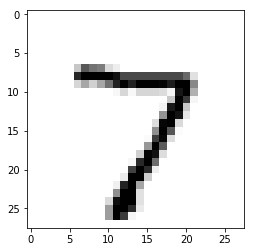

In [8]:
import matplotlib.pyplot as plt

# Anzeige des ersten Bildes im Testdatensatz:
# Erkannt werden kann visuell die Ziffer 7
alle_werte = test_data_list[0].split(',') # Pixel des i-ten Bild einlesen und Kommas entfernen
bild_array = np.asfarray(alle_werte[1:]).reshape((28,28)) # Erster Wert Liste(= target) abtrennen, reshapen
plt.imshow(bild_array, cmap = "Greys", interpolation = "None")
print("Ziffer auf dem Bild: ", alle_werte[0])  

In [9]:
# Abfrage Neuronales Netz 
input_pixel = (np.asfarray(alle_werte[1:]) / 255.0 * 0.99) + 0.01
prediction = nn.query(input_pixel)
print(prediction)
np.argmax(prediction) 

[[0.02087564]
 [0.01084734]
 [0.01777233]
 [0.10529556]
 [0.05438842]
 [0.01332317]
 [0.00871472]
 [0.87516335]
 [0.0322482 ]
 [0.02579167]]


7

<b><font color=blue>Neuronales Netz ist in der Lage Das ERSTE Bild mit nur 100 Trainingsdatensätzen richtig zu klassifizieren!</font></b>

#### Evaluation Neuronales Netz 

-  Accuracy bestimmen für gesamten Testdatensatz

In [10]:
# Testdatensatz laden
data_file = open("mnist_test_10.csv", 'r')
test_data_list = data_file.readlines() 
data_file.close()

wertungsliste = []

for record in test_data_list:
    alle_werte = record.split(',')
    target = int(alle_werte[0]) 
    print()
    input_pixel = (np.asfarray(alle_werte[1:]) / 255.0 * 0.99) + 0.01
    prediction = np.argmax(nn.query(input_pixel))
    print("Korrekte Ziffer: {} Prediction: {}".format(target,prediction)) 
    
    if (target == prediction):
        wertungsliste.append(1)
    else:
        wertungsliste.append(0)
        
print("")        
print("Wertungsliste: ", wertungsliste) 
accuracy = np.array(wertungsliste).sum() / np.array(wertungsliste).size
print("Accuracy: ", accuracy) 


Korrekte Ziffer: 7 Prediction: 7

Korrekte Ziffer: 2 Prediction: 6

Korrekte Ziffer: 1 Prediction: 1

Korrekte Ziffer: 0 Prediction: 0

Korrekte Ziffer: 4 Prediction: 4

Korrekte Ziffer: 1 Prediction: 1

Korrekte Ziffer: 4 Prediction: 4

Korrekte Ziffer: 9 Prediction: 3

Korrekte Ziffer: 5 Prediction: 4

Korrekte Ziffer: 9 Prediction: 7

Wertungsliste:  [1, 0, 1, 1, 1, 1, 1, 0, 0, 0]
Accuracy:  0.6


## Neuronales Netz mit gesamten MNIST-Dataset

<br/>

-  CSV-Files heruntergeladen von https://pjreddie.com/projects/mnist-in-csv/
-  Trainingsdatensatz 60.000 Ziffern (mnist_train.csv)
-  Testdatensatz 10.000 Ziffern (mnist_test.csv)

In [11]:
data_file = open("mnist_train.csv", 'r')
training_data_list = data_file.readlines() 
data_file.close()
print("Trainingsdatensatz: ", len(training_data_list))
data_file = open("mnist_test.csv", 'r')
training_data_list = data_file.readlines() 
data_file.close()
print("Testdatensatz: ", len(training_data_list))

Trainingsdatensatz:  60000
Testdatensatz:  10000


In [16]:
import numpy as np
import scipy.special # Sigmoid-Aktivierungsfunktion liegt als "expit()" in dieser Bibliothek

class neuronalesNetz:
    
    # Initialisierung Netzarchitektur
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        self.innodes = inputnodes
        self.hidnodes = hiddennodes
        self.outnodes = outputnodes
        self.lr = learningrate       
        
        self.wih = np.random.normal(loc=0.0, scale=pow(self.hidnodes, -0.5), size=(self.hidnodes, self.innodes))
        self.who = np.random.normal(loc=0.0, scale=pow(self.outnodes, -0.5), size=(self.outnodes, self.hidnodes)) 
        
        self.activation_function = lambda x: scipy.special.expit(x)
        pass

    
    # Gewichte anhand Trainingsbeispielen trainieren
    def train(self,input_list, target_list): 

        inputs = np.array(input_list, ndmin = 2).T 
        targets = np.array(target_list, ndmin = 2).T

        # 1. Ausgabe für Trainingsbeispiel von Netz berechnen lassen
        hidden_in = np.dot(self.wih, inputs) 
        hidden_out = self.activation_function(hidden_in) 
        output_in = np.dot(self.who, hidden_out) 
        output_out = self.activation_function(output_in)

        # 2. Fehler der Ausgabe berechnen + Fehlerrückrechnung
        output_errors = targets - output_out
        hidden_errors = np.dot(self.who.T, output_errors)

        # Gewichtsktualisierung für who und wih
        self.who += self.lr * np.dot((output_errors * output_out * (1.0 - output_out)), np.transpose(hidden_out))
        self.wih += self.lr * np.dot((hidden_errors * hidden_out * (1.0 - hidden_out)), np.transpose(inputs))       
        pass
 

    # für gegebenen Input, einen Ouput vom Neuronalen Netz abfragen
    def query(self, input_list):   
        
        inputs = np.array(input_list, ndmin = 2).T # ndmin: minimum number of dimensions the resulting array should have
        
        # Verarbeitung Eingabe bis Ausgabe Hidden-Schicht
        hidden_in = np.dot(self.wih, inputs) # Punktprodukt/Matrixmultiplikation/Skalarprodukt
        hidden_out = self.activation_function(hidden_in) # Sigmoid-Aktivierungsfunktion auf Signal anwenden
        
        # Verarbeitung Ausgabe Hidden-Schicht bis finale Ausgabe
        output_in = np.dot(self.who, hidden_out) 
        output_out = self.activation_function(output_in) 
        return output_out
 

# Training
data_file = open("mnist_train.csv", 'r')
training_data_list = data_file.readlines() 
data_file.close()

# Erstellung Neuronales Netz
input_nodes = 784 #(28 X 28 Pixel)
hidden_nodes = 100 
output_nodes = 10 # target ist Ziffer zwischen 0 und 9 (=10 mögliche Zielewerte)
lr = 0.2

nn = neuronalesNetz(input_nodes, hidden_nodes, output_nodes, lr) 

# Training für jeden der 100 Datensätze im train-set ausführen
for record in training_data_list: 
    alle_werte = record.split(',')
    input_pixel = (np.asfarray(alle_werte[1:]) / 255.0 * 0.99) + 0.01 # Skalierung 784 Pixelwerte
    zielmatrix = np.zeros(output_nodes) + 0.01
    zielmatrix[int(alle_werte[0])] = 0.99 # Zuweisung Target Zielwert 0.99 
    nn.train(input_pixel, zielmatrix)
    if ((training_data_list.index(record)+1)%10000 == 0):
        print("Anzahl Datensätze trainiert: ", training_data_list.index(record)+1)
    pass   

# Testen
data_file = open("mnist_test.csv", 'r')
test_data_list = data_file.readlines() 
data_file.close()

wertungsliste = []

for record in test_data_list:
    alle_werte = record.split(',')
    target = int(alle_werte[0]) 
    input_pixel = (np.asfarray(alle_werte[1:]) / 255.0 * 0.99) + 0.01
    prediction = np.argmax(nn.query(input_pixel))
    
    if (target == prediction):
        wertungsliste.append(1)
    else:
        wertungsliste.append(0)
    pass

print("")
accuracy = np.array(wertungsliste).sum() / np.array(wertungsliste).size
print("Accuracy: ", accuracy) 

Anzahl Datensätze trainiert:  10000
Anzahl Datensätze trainiert:  20000
Anzahl Datensätze trainiert:  30000
Anzahl Datensätze trainiert:  40000
Anzahl Datensätze trainiert:  50000
Anzahl Datensätze trainiert:  60000

Accuracy:  0.9495


#### Accuracy des Neuronalen Netzes verbessern

-  Training mit Trainingsdaten mehrmals wiederholen → 5 Epochen
-  Anpassung Lernrate: Reduzierug Lernrate auf 0.1
-  Anzahl Knoten Hidden Layer erhöhen um Kernkapazität Neuronale Netz zu verbessern → hidnodes = 200

In [18]:
import numpy as np
import scipy.special # Sigmoid-Aktivierungsfunktion liegt als "expit()" in dieser Bibliothek

class neuronalesNetz:
    
    # Initialisierung Netzarchitektur
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        self.innodes = inputnodes
        self.hidnodes = hiddennodes
        self.outnodes = outputnodes
        self.lr = learningrate       
        
        self.wih = np.random.normal(loc=0.0, scale=pow(self.hidnodes, -0.5), size=(self.hidnodes, self.innodes))
        self.who = np.random.normal(loc=0.0, scale=pow(self.outnodes, -0.5), size=(self.outnodes, self.hidnodes)) 
        
        self.activation_function = lambda x: scipy.special.expit(x)
        pass

    
    # Gewichte anhand Trainingsbeispielen trainieren
    def train(self,input_list, target_list): 

        inputs = np.array(input_list, ndmin = 2).T 
        targets = np.array(target_list, ndmin = 2).T

        # 1. Ausgabe für Trainingsbeispiel von Netz berechnen lassen
        hidden_in = np.dot(self.wih, inputs) 
        hidden_out = self.activation_function(hidden_in) 
        output_in = np.dot(self.who, hidden_out) 
        output_out = self.activation_function(output_in)

        # 2. Fehler der Ausgabe berechnen + Fehlerrückrechnung
        output_errors = targets - output_out
        hidden_errors = np.dot(self.who.T, output_errors)

        # Gewichtsktualisierung für who und wih
        self.who += self.lr * np.dot((output_errors * output_out * (1.0 - output_out)), np.transpose(hidden_out))
        self.wih += self.lr * np.dot((hidden_errors * hidden_out * (1.0 - hidden_out)), np.transpose(inputs))       
        pass
 

    # für gegebenen Input, einen Ouput vom Neuronalen Netz abfragen
    def query(self, input_list):   
        
        inputs = np.array(input_list, ndmin = 2).T # ndmin: minimum number of dimensions the resulting array should have
        
        # Verarbeitung Eingabe bis Ausgabe Hidden-Schicht
        hidden_in = np.dot(self.wih, inputs) # Punktprodukt/Matrixmultiplikation/Skalarprodukt
        hidden_out = self.activation_function(hidden_in) # Sigmoid-Aktivierungsfunktion auf Signal anwenden
        
        # Verarbeitung Ausgabe Hidden-Schicht bis finale Ausgabe
        output_in = np.dot(self.who, hidden_out) 
        output_out = self.activation_function(output_in) 
        return output_out
 

# Training
data_file = open("mnist_train.csv", 'r')
training_data_list = data_file.readlines() 
data_file.close()

# Erstellung Neuronales Netz
input_nodes = 784 #(28 X 28 Pixel)
hidden_nodes = 200 # Lernkapazität steigern
output_nodes = 10 # target ist Ziffer zwischen 0 und 9 (=10 mögliche Zielewerte)
lr = 0.1 # Reduzierug Lernrate auf 0.1

nn = neuronalesNetz(input_nodes, hidden_nodes, output_nodes, lr) 
epochs = 5 # Komplettes Training mehrmals ausführen

# Training für jeden der 100 Datensätze im train-set ausführen
for e in range(epochs):
    for record in training_data_list: 
        alle_werte = record.split(',')
        input_pixel = (np.asfarray(alle_werte[1:]) / 255.0 * 0.99) + 0.01 # Skalierung 784 Pixelwerte
        zielmatrix = np.zeros(output_nodes) + 0.01
        zielmatrix[int(alle_werte[0])] = 0.99 # Zuweisung Target Zielwert 0.99 
        nn.train(input_pixel, zielmatrix)
        if ((training_data_list.index(record)+1)%10000 == 0):
            print("Anzahl Datensätze trainiert: ", training_data_list.index(record)+1)
        pass   
    pass

# Testen
data_file = open("mnist_test.csv", 'r')
test_data_list = data_file.readlines() 
data_file.close()

wertungsliste = []

for record in test_data_list:
    alle_werte = record.split(',')
    target = int(alle_werte[0]) 
    input_pixel = (np.asfarray(alle_werte[1:]) / 255.0 * 0.99) + 0.01
    prediction = np.argmax(nn.query(input_pixel))
    
    if (target == prediction):
        wertungsliste.append(1)
    else:
        wertungsliste.append(0)
    pass

print("")
accuracy = np.array(wertungsliste).sum() / np.array(wertungsliste).size
print("Accuracy: ", accuracy) 

Anzahl Datensätze trainiert:  10000
Anzahl Datensätze trainiert:  20000
Anzahl Datensätze trainiert:  30000
Anzahl Datensätze trainiert:  40000
Anzahl Datensätze trainiert:  50000
Anzahl Datensätze trainiert:  60000
Anzahl Datensätze trainiert:  10000
Anzahl Datensätze trainiert:  20000
Anzahl Datensätze trainiert:  30000
Anzahl Datensätze trainiert:  40000
Anzahl Datensätze trainiert:  50000
Anzahl Datensätze trainiert:  60000
Anzahl Datensätze trainiert:  10000
Anzahl Datensätze trainiert:  20000
Anzahl Datensätze trainiert:  30000
Anzahl Datensätze trainiert:  40000
Anzahl Datensätze trainiert:  50000
Anzahl Datensätze trainiert:  60000
Anzahl Datensätze trainiert:  10000
Anzahl Datensätze trainiert:  20000
Anzahl Datensätze trainiert:  30000
Anzahl Datensätze trainiert:  40000
Anzahl Datensätze trainiert:  50000
Anzahl Datensätze trainiert:  60000
Anzahl Datensätze trainiert:  10000
Anzahl Datensätze trainiert:  20000
Anzahl Datensätze trainiert:  30000
Anzahl Datensätze trainiert:

# Accuracy 97,42%

<b><font color=blue>Rechenzeit ca. 15min mit CPU</font></b>